In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import torch
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay   
import sdfpred_utils.sdfpred_utils as su
import sdfpred_utils.loss_functions as lf

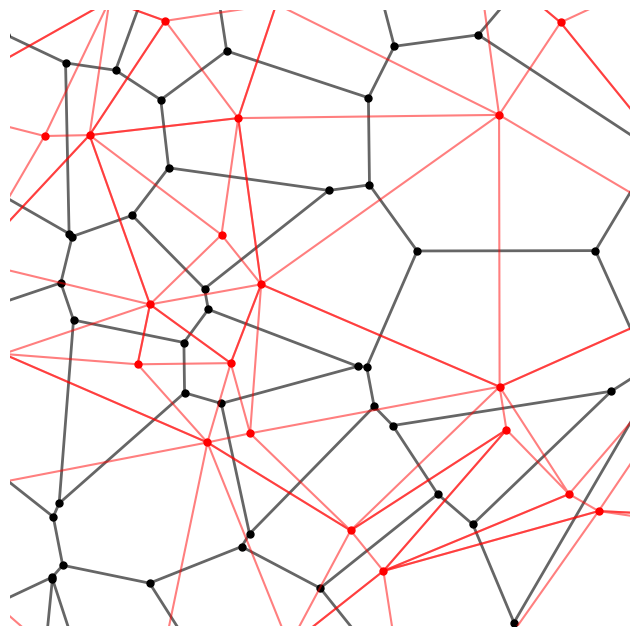

In [ ]:
N = 100

# Improve reproducibility
torch.manual_seed(69)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(69)

# Generate N site positions
site_positions = np.random.rand(N, 2) * 100

def plot_voronoi_diagram(site_positions, output, aux_points=None):
    # Create a Voronoi diagram
    vor = Voronoi(site_positions)

    # Plot the Voronoi diagram
    fig, ax = plt.subplots(figsize=(8, 8))
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=2, line_alpha=0.6, point_size=2)

    # Add site positions
    ax.plot(site_positions[:, 0], site_positions[:, 1], 'ro', markersize=5, label='Sites')

    # Add vertices (black)
    ax.plot(vor.vertices[:, 0], vor.vertices[:, 1], 'o', markersize=5, label='Vertices', color='black')

    # Make the connection between adjacent sites
    tri = Delaunay(site_positions)
    for simplex in tri.simplices:
        ax.plot(site_positions[simplex, 0], site_positions[simplex, 1], 'r-', alpha=0.5)

    # DEBUG: Show the Voronoi
    # cell_centers = np.array([vor.vertices[vor.regions[i]].mean(axis=0) for i in range(len(vor.regions)) if len(vor.regions[i]) > 0])
    # ax.plot(cell_centers[:, 0], cell_centers[:, 1], 'go', markersize=5, label='Cell Centers')
    if aux_points is not None:
        ax.scatter(aux_points[:, 0], aux_points[:, 1], c='blue', s=5, label='Aux Points')
        
    # Crop important area
    ax.set_xlim(20, 80)
    ax.set_ylim(20, 80)

    # Remove all axes
    ax.axis('off')

    # Save as svg
    plt.savefig(output, format='svg', bbox_inches='tight')
    plt.show()

plot_voronoi_diagram(site_positions, 'voronoi_diagram.svg')

CVT Loss: 14.501614570617676
torch.Size([3789, 2])
CVT X: tensor([[  32.6829,   80.9068],
        [  32.7186,   81.0050],
        [  32.7553,   81.1057],
        ...,
        [-148.9957,  147.3550],
        [-251.7224,  190.2770],
        [-743.1055,  395.5899]], device='cuda:0')


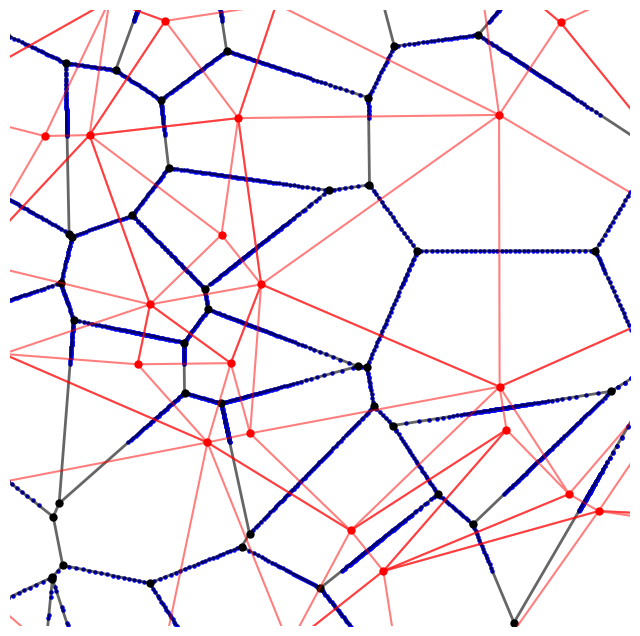

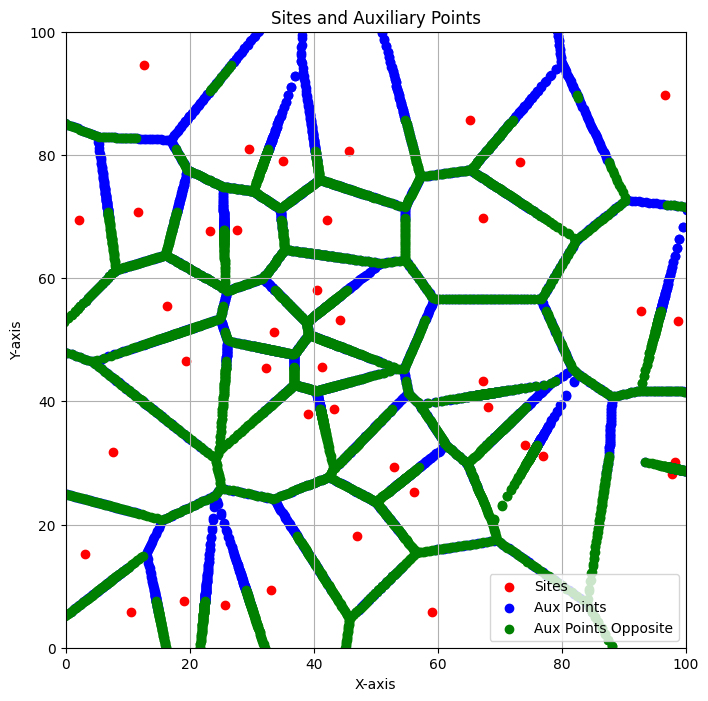

In [3]:
cvt_loss, x, xp = lf.compute_cvt_dist(torch.tensor(site_positions, dtype=torch.float32, device=0), M=100, N=40, random=False, max_distance=1000)
print(f'CVT Loss: {cvt_loss.item()}')
print(x.shape)
print(f'CVT X: {x}')
plot_voronoi_diagram(site_positions, 'voronoi_diagram_with_aux.svg', aux_points=x.detach().cpu().numpy())

# Plot all points in x
plt.figure(figsize=(8, 8))
plt.scatter(site_positions[:, 0], site_positions[:, 1], c='red', label='Sites')
plt.scatter(x[:, 0].detach().cpu().numpy(), x[:, 1].detach().cpu().numpy(), c='blue', label='Aux Points')
plt.scatter(xp[:, 0].detach().cpu().numpy(), xp[:, 1].detach().cpu().numpy(), c='green', label='Aux Points Opposite')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend()
plt.title('Sites and Auxiliary Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.savefig('sites_and_aux_points.svg', format='svg', bbox_inches='tight')
plt.show()


Energy: 5.661681652069092
Energy: 5.729926109313965
Energy: 5.517889499664307
Energy: 5.483781337738037
Energy: 5.568600177764893
Energy: 5.443544387817383
Energy: 5.575384616851807
Energy: 5.526780128479004
Energy: 5.552844524383545
Energy: 5.461065292358398
Energy: 5.457667827606201
Energy: 5.473693370819092
Energy: 5.4719719886779785
Energy: 5.517063140869141
Energy: 5.440670967102051
Energy: 5.375725746154785
Energy: 5.425414562225342
Energy: 5.3767876625061035
Energy: 5.425190448760986
Energy: 5.404083251953125
Energy: 5.337179183959961
Energy: 5.296152591705322
Energy: 5.263259410858154
Energy: 5.389128684997559
Energy: 5.379660606384277
Energy: 5.221306324005127
Energy: 5.399255752563477
Energy: 5.316232204437256
Energy: 5.2281599044799805
Energy: 5.2416791915893555
Energy: 5.227536201477051
Energy: 5.333170413970947
Energy: 5.227108001708984
Energy: 5.1961870193481445
Energy: 5.290493488311768
Energy: 5.170957088470459
Energy: 5.172073841094971
Energy: 5.103339195251465
Energy:

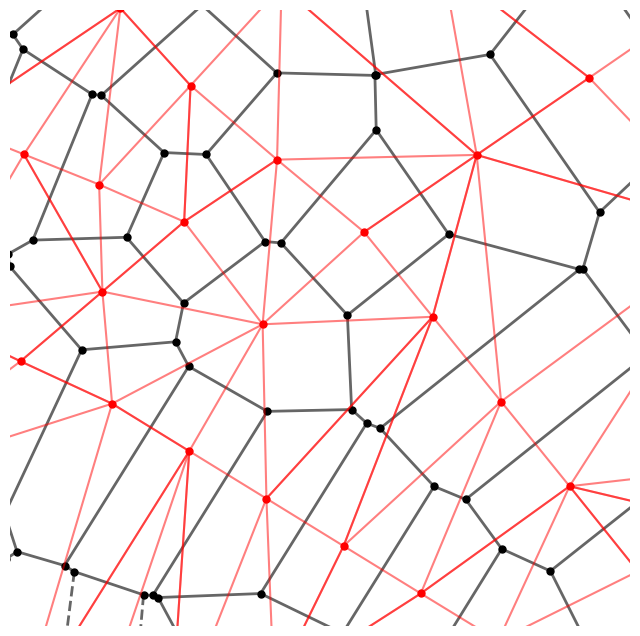

In [4]:
# Optimize the site position with pytorch to minimize the CVT energy
site_positions_tensor = torch.tensor(site_positions, dtype=torch.float32, requires_grad=True, device=0)
optimizer = torch.optim.Adam([site_positions_tensor], lr=0.01)

torch.autograd.set_detect_anomaly(True)

for _ in range(2000):
    optimizer.zero_grad()
    d3dsimplices = Delaunay(site_positions_tensor.detach().cpu().numpy()).simplices
    cvt_loss, _, _ = lf.compute_cvt_dist(site_positions_tensor, N=40, max_distance=40)
    energy = cvt_loss.mean()
    energy.backward()
    print(f'Energy: {energy.item()}')
    optimizer.step()

# Plot the optimized Voronoi diagram
optimized_site_positions = site_positions_tensor.detach().cpu().numpy()
plot_voronoi_diagram(optimized_site_positions, 'optimized_voronoi_diagram.svg')